# Ethereum transactions in PubSub

## DESCRIPTION
In this notebook, there're two functions wich executed at a specific time interval.
Function "handling_messages" gets data from PubSub by a subscriber. This function is executed at every PULLING_WAIT_SECONDS seconds and get NUM_MESSAGES messages from PubSub. Data from each message is counted in dataframe "df" in an appropriate time interval, which defined in TIME_WINDOW.
Function "draw_graph" is executed at every DRAWING_WAIT_SECONDS seconds, get data from "df" and draw a graph with candlesticks. This function uses a value of MAX_CANDLESTICKS_ON_GRAPH to limit a quantity of sticks on the graph.

### Import modules

In [1]:
from google.cloud import pubsub_v1
import json
import pandas as pd
import time
import datetime
import plotly.graph_objects as go
import time, threading
from IPython.display import clear_output

### Setting constants:

In [2]:
# put your project ID here
PROJECT_ID = "<PROJECT ID>"

SUBSCRIPTION_NAME = "crypto_ethereum.transactions"
NUM_MESSAGES = 1000
PULLING_WAIT_SECONDS = 5
DRAWING_WAIT_SECONDS = 10
TIME_WINDOW = 30 # in seconds
MAX_CANDLESTICKS_ON_GRAPH = 20
PRICE_SCALE = 1000000000

subscriber = pubsub_v1.SubscriberClient()
subscription_path = subscriber.subscription_path(
    PROJECT_ID, SUBSCRIPTION_NAME
)

### Define timers for background updates

In [3]:
timers = {
    'handle': None,
    'draw': None
}

### Function "handling_messages" pull messages and calculate candles over fixed windows

In [4]:
def handling_messages():
    global NUM_MESSAGES, PULLING_WAIT_SECONDS, df, current_timestamp, last_receiving_datetime, total_received_messages, max_timestamp, error_counter
    
    response = subscriber.pull(subscription_path, max_messages=NUM_MESSAGES)
    
    ack_ids = []
    for received_message in response.received_messages:
        data = json.loads(received_message.message.data.decode('utf8'))
        block_timestamp = data['block_timestamp']
        gas_price = float(data['gas_price'])/PRICE_SCALE
        
        unix_timestamp = int(block_timestamp)
        current_timestamp = int(unix_timestamp/TIME_WINDOW)*TIME_WINDOW
            
        indexes = df['unix_timestamp'][df['unix_timestamp'] == current_timestamp].index
        if (indexes.size == 0):
            df = df.append({'unix_timestamp': current_timestamp, 'min_price':gas_price, 'max_price':gas_price, 'open_price':gas_price, 'close_price':gas_price}, ignore_index=True)
        else:
            index = indexes[0]
            min_price = min(gas_price, df['min_price'][index])
            max_price = max(gas_price, df['max_price'][index])
            df.loc[[index], 'min_price'] = min_price
            df.loc[[index], 'max_price'] = max_price
            df.loc[[index], 'close_price'] = gas_price

        ack_ids.append(received_message.ack_id)
    try:
        subscriber.acknowledge(subscription_path, ack_ids)
    except Exception as e:
        error_counter += 1

    last_receiving_datetime = datetime.datetime.now()
    total_received_messages += len(response.received_messages)
    
    timers['handle'] = threading.Timer(PULLING_WAIT_SECONDS, handling_messages)
    timers['handle'].start()


### Function "draw_graph" draw and periodically updates candlestick chart

In [5]:
def draw_graph():
    global DRAWING_WAIT_SECONDS, df
    
    graph_df = df.tail(MAX_CANDLESTICKS_ON_GRAPH)
    graph_df['date'] = graph_df.apply(lambda row: datetime.datetime.fromtimestamp(row.unix_timestamp), axis = 1)
    
    first_date_on_graph = min(graph_df['date'])
    last_date_on_graph = max(graph_df['date'])
    
    clear_output(wait=True)
    
    fig = go.Figure(data=[go.Candlestick(x=graph_df['date'],
                open=graph_df['open_price'], high=graph_df['max_price'],
                low=graph_df['min_price'], close=graph_df['close_price'])],
                layout=go.Layout(
                    width=1200,
                    height=600,
                ))
    fig.update_layout(
        title_text="Last receiving messages date: {}<br>Total messages: {}<br>First date on graph: {}<br>Last date on graph: {}".format(last_receiving_datetime.strftime("%Y-%m-%d %H:%M:%S"), total_received_messages, first_date_on_graph, last_date_on_graph),
        font=dict(family="Courier New, monospace", size=8, color="#7f7f7f")
    )
    fig.show()

    timers['draw'] = threading.Timer(DRAWING_WAIT_SECONDS, draw_graph)
    timers['draw'].start()

### Initialize needed variables and starting functions "handling_messages" and "draw_graph"

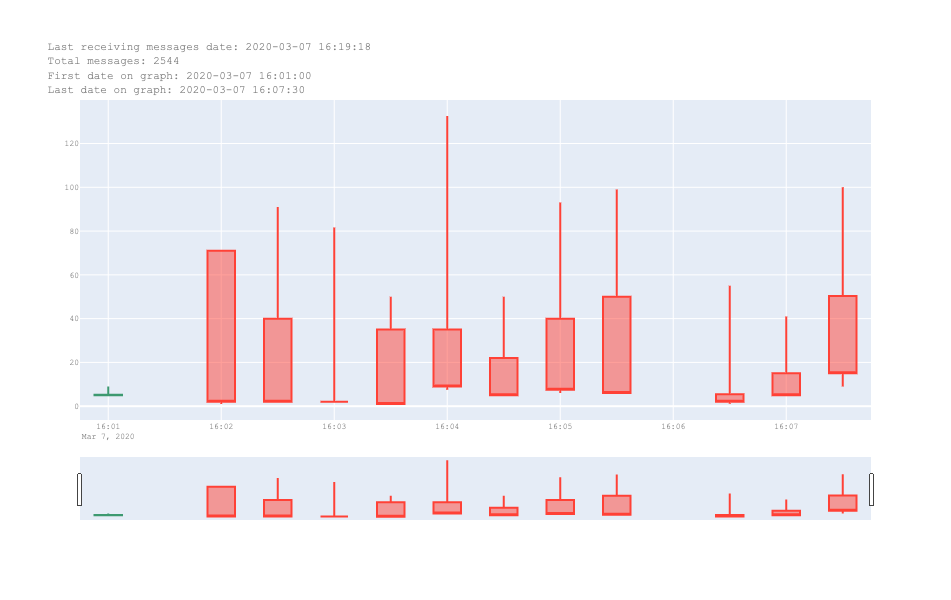

In [6]:
# STEP 5

df = pd.DataFrame(columns = ['unix_timestamp', 'min_price', 'max_price', 'open_price', 'close_price'])

last_receiving_datetime = None
total_received_messages = 0
current_timestamp = 0
max_timestamp = 0
receiving_process_running = True
error_counter = 0

handling_messages()
draw_graph()

### Cancel timers and print statistics

In [7]:
timers['handle'].cancel()
timers['draw'].cancel()
print("Last date: {}\nTotal messages: {}\n".format(last_receiving_datetime.strftime("%Y-%m-%d %H:%M:%S"), total_received_messages))

Last date: 2020-03-07 16:19:24
Total messages: 2615

